In [30]:
import pandas as pd
import networkx as nx

# Load nodes and edges from CSV files
nodes_df = pd.read_csv('Node.csv')
edges_df = pd.read_csv('Edge.csv')

# Create a graph
G = nx.Graph()

In [31]:
#Generating Binary Labels for Optimal Route --- Binary Classification
#Create a DataFrame to store transportation costs for each edge
transportation_costs = pd.DataFrame(columns=['edge_id', 'transportation_cost'])

# Calculate transportation costs based on the provided edges data
for _, edge_data in edges_df.iterrows():
    edge_id = edge_data['edge_id']
    distance = edge_data['distance']
    cost_per_km = edge_data['cost_per_km']
    transportation_cost = distance * cost_per_km
    #print(transportation_cost)
    transportation_costs = transportation_costs._append({'edge_id': edge_id, 'transportation_cost': transportation_cost}, ignore_index=True)
    #print(transportation_costs)

# Sort edges by transportation cost in ascending order
sorted_edges = transportation_costs.sort_values(by='transportation_cost', ascending=True)
print(sorted_edges)

# Assuming you want to label the top 10% of edges as optimal routes #top 10%?
num_optimal_routes = int(0.1 * len(sorted_edges))
print(num_optimal_routes)
optimal_edges = sorted_edges.head(num_optimal_routes)['edge_id'].tolist()

# Create binary labels based on whether the edge is in the optimal routes list #binary labels?
edges_df['is_optimal'] = edges_df['edge_id'].isin(optimal_edges).astype(int)

# Display the resulting DataFrame with binary labels
print(edges_df[['edge_id', 'is_optimal']])

    edge_id  transportation_cost
12     13.0                 2.25
32     33.0                 2.40
22     23.0                 2.40
42     43.0                 2.40
10     11.0                 2.40
17     18.0                 3.00
1       2.0                 3.00
31     32.0                 3.00
21     22.0                 3.00
41     42.0                 3.00
26     27.0                 3.50
46     47.0                 3.50
36     37.0                 3.50
24     25.0                 3.60
44     45.0                 3.60
34     35.0                 3.60
6       7.0                 3.85
14     15.0                 4.00
8       9.0                 4.00
16     17.0                 4.20
4       5.0                 5.40
20     21.0                 5.50
40     41.0                 5.50
30     31.0                 5.50
37     38.0                 6.00
27     28.0                 6.00
47     48.0                 6.00
2       3.0                 6.00
39     40.0                 7.20
49     50.

/tmp/ipykernel_8149/950695611.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transportation_costs = transportation_costs._append({'edge_id': edge_id, 'transportation_cost': transportation_cost}, ignore_index=True)


In [51]:
#Converting the Categorical cols - type from node_df and mode from edge_df to convert to tensors 
import torch
import pandas as pd
import networkx as nx
from torch_geometric.data import Data

for _, node_data in nodes_df.iterrows():
    node_id = node_data['node_id']
    G.add_node(node_id, type=node_data['type'], latitude=node_data['latitude'], longitude=node_data['longitude'], capacity=node_data['capacity'])

# One-hot encode the 'type' column
one_hot_encoded_types = pd.get_dummies(nodes_df['type'], prefix='type')
#print(one_hot_encoded_types)

# Concatenate the one-hot encoded types with the original node features
node_features = pd.concat([nodes_df[['latitude', 'longitude', 'capacity']], one_hot_encoded_types], axis=1)

# Convert only numeric columns in node_features to a tensor
numeric_node_features = node_features.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).values
node_features_tensor = torch.tensor(numeric_node_features, dtype=torch.float)

# Extract only numeric columns for edge features
numeric_edge_features = edges_df[['distance', 'cost_per_km']].values
edge_features_tensor = torch.tensor(numeric_edge_features, dtype=torch.float)

# Extract edge_index
edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()

# Extract binary labels for optimal routes (assuming you have already generated these labels)
labels = torch.tensor(edges_df['is_optimal'].values, dtype=torch.long)

# Create a PyTorch Geometric Data object with one-hot encoded types and binary labels
data = Data(x=node_features_tensor, edge_index=edge_index, edge_attr=edge_features_tensor, y=labels)

# Display the data
print("Node Features:")
print(node_features_tensor)
print("\nEdge Index:")
print(edge_index)
print("\nEdge Features:")
print(edge_features_tensor)
print("\nBinary Labels (is_optimal):")
print(labels)

# You can use the 'data' object in your GNN model for training and testing.

Node Features:
tensor([[  37.7749, -122.4194, 1000.0000],
        [  34.0522, -118.2437,  500.0000],
        [  40.7128,  -74.0060,  800.0000],
        [  41.8781,  -87.6298,       nan],
        [  32.7767,  -96.7970, 1200.0000],
        [  29.7604,  -95.3698,  600.0000],
        [  35.6895, -105.9378, 1000.0000],
        [  39.9526,  -75.1652,       nan],
        [  40.7128,  -74.0060,  800.0000],
        [  37.7749, -122.4194,  400.0000],
        [  34.0522, -118.2437,  600.0000],
        [  32.7767,  -96.7970,       nan],
        [  29.7604,  -95.3698, 1100.0000],
        [  35.6895, -105.9378,  550.0000],
        [  39.9526,  -75.1652,  750.0000],
        [  41.8781,  -87.6298,       nan],
        [  34.0522, -118.2437,  900.0000],
        [  32.7767,  -96.7970,  450.0000],
        [  29.7604,  -95.3698,  700.0000],
        [  35.6895, -105.9378,       nan],
        [  39.9526,  -75.1652, 1000.0000],
        [  41.8781,  -87.6298,  500.0000],
        [  37.7749, -122.4194,  700.000

In [39]:
#Node Mapping -- Index out of bounds for edge_index
import torch
import networkx as nx
from torch_geometric.data import Data

# Assuming you have nodes_df and edges_df dataframes

# Create a NetworkX graph and add nodes with attributes
G = nx.Graph()

# Mapping to keep track of node indices
node_mapping = {}

for _, node_data in nodes_df.iterrows():
    node_id = node_data['node_id']
    G.add_node(node_id, type=node_data['type'], latitude=node_data['latitude'], longitude=node_data['longitude'], capacity=node_data['capacity'])
    
    # Add the node to the mapping
    node_mapping[node_id] = len(node_mapping)

# Add edges with attributes
for _, edge_data in edges_df.iterrows():
    source_node_id = edge_data['source_node_id']
    destination_node_id = edge_data['destination_node_id']
    
    # Check if the node indices are within bounds
    if source_node_id not in node_mapping or destination_node_id not in node_mapping:
        print(f"Error: Invalid node indices in edge ({source_node_id}, {destination_node_id}). Check the graph construction.")
    else:
        # Use the mapped indices
        source_node_index = node_mapping[source_node_id]
        destination_node_index = node_mapping[destination_node_id]
        
        G.add_edge(source_node_index, destination_node_index, edge_id=edge_data['edge_id'],
                   distance=edge_data['distance'], mode=edge_data['mode'],
                   cost_per_km=edge_data['cost_per_km'],
                   time_window_start=edge_data['time_window_start'],
                   time_window_end=edge_data['time_window_end'])

# Get the edge_index from the NetworkX graph
edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()

# Create a PyTorch Geometric Data object
data = Data(x=node_features_tensor, edge_index=edge_index, edge_attr=edge_features_tensor, y=labels)

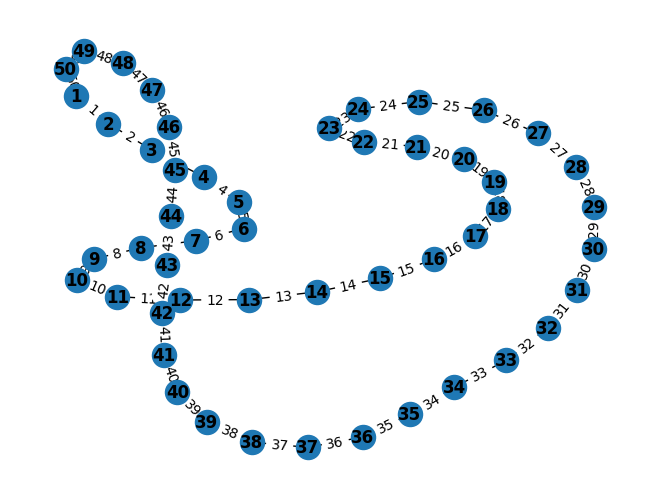

In [34]:
#Optional: Visualize the graph
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)  # Choose a layout for visualization
nx.draw(G, pos, with_labels=True, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'edge_id')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [35]:
# Print basic information about the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 50
Number of edges: 50


In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class YourGNNModel(nn.Module):
    def __init__(self, node_feature_dim, edge_feature_dim, hidden_dim, output_dim):
        super(YourGNNModel, self).__init__()
        self.conv1 = GCNConv(node_feature_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
      

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # Use the first dimension of edge features as edge weights
        edge_weight = edge_attr[:, 0].view(-1, 1)  

        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
                

        return F.log_softmax(x, dim=1)

    
# Assuming your node features have a dimensionality of 3 and edge features have a dimensionality of 2
node_feature_dim = 3
edge_feature_dim = 2
hidden_dim = 64
output_dim = 2

model = YourGNNModel(node_feature_dim, edge_feature_dim, hidden_dim, output_dim)

In [48]:
import torch
import torch.nn as nn
import torch_geometric.nn as gnn
from torch_geometric.data import Data, DataLoader

# Create a DataLoader for the data
data_list = [data]  # You can extend this list if you have multiple graphs
loader = DataLoader(data_list, batch_size=1, shuffle=False)

# Instantiate the GNN model
node_feature_dim = node_features_tensor.shape[1]
edge_feature_dim = edge_features_tensor.shape[1]
hidden_dim = 64
output_dim = 2  # Binary classification: optimal route or not

model = YourGNNModel(node_feature_dim, edge_feature_dim, hidden_dim, output_dim)



In [49]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() #Loss used for Classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model (you can adjust this based on your data)
for epoch in range(100): 
        for batch in loader:
                # Forward pass
                #print("Node Features Shape:", batch.x.shape)
                #print("Edge Index Shape:", batch.edge_index.shape)
                #print("Edge Features Shape:", batch.edge_attr.shape)
        
                output = model(batch)
                
                # Example: Assuming you have binary labels for optimal routes (1) or not (0)
                labels = batch.y

                # Compute loss
                loss = criterion(output, labels)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

        # After training, you can use the trained model to predict optimal routes for new instances.

Epoch 0, Loss: nan
Epoch 10, Loss: nan
Epoch 20, Loss: nan
Epoch 30, Loss: nan
Epoch 40, Loss: nan
Epoch 50, Loss: nan
Epoch 60, Loss: nan
Epoch 70, Loss: nan
Epoch 80, Loss: nan
Epoch 90, Loss: nan


In [50]:
# Recommendation System: Get the predictions for the edges
model.eval()
with torch.no_grad():
            predictions = model(data)

# Assuming you want to recommend the top k cost-effective routes
k = min(10, len(data.edge_index[0]))
top_k_indices = torch.topk(predictions[:, 1], k).indices.numpy()

# Display recommended routes
recommended_routes = edges_df.iloc[top_k_indices]
print("Recommended Routes:")
print(recommended_routes)

Recommended Routes:
    edge_id  source_node_id  destination_node_id  distance   mode  \
31       32              32                   33        25  Truck   
37       38              38                   39        30  Truck   
36       37              37                   38        35  Train   
35       36              36                   37        50  Truck   
34       35              35                   36        40  Train   
33       34              34                   35        60  Truck   
32       33              33                   34        30  Train   
28       29              29                   30        50  Train   
26       27              27                   28        35  Train   
27       28              28                   29        30  Truck   

    cost_per_km time_window_start time_window_end  is_optimal  
31         0.12           3:00 PM         6:00 PM           0  
37         0.20           8:00 AM        12:00 PM           0  
36         0.10           2: